# Testing code for project segments

#### CVAR test

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm, chi2

from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianNode
from swarm_prm.envs.map import Map, CircleObstacle


def obstacle_gaussian_collision(obs: CircleObstacle, g_node: GaussianNode, alpha, thresh, ax) -> bool:
    """
        Using CVaR and threshold to test if node is too close to obstacle.
        Return True if CVaR is greater than the threshold.
        Reference: SwarmPRM
    """

    # Plot normal vector
    mean = -obs.get_dist(g_node.get_mean())
    v_normal = (obs.pos - g_node.get_mean()) / (np.linalg.norm(obs.pos - g_node.get_mean()))
    start_pos = g_node.get_mean()
    end_pos = start_pos - v_normal * mean
    vec = np.vstack([start_pos, end_pos]).T
    ax.plot(vec[0], vec[1])

    variance = v_normal.T @ g_node.covariance @ v_normal
    ita = norm(mean, variance)
    cvar = mean + ita.pdf(ita.ppf(1-alpha))/alpha * variance
    # print(cvar)
    return cvar > thresh

def visualize_g_node(g_node, ax, thresh, is_collision):
    # Visualize G nodes
    mean, cov = g_node.get_gaussian()
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors by descending eigenvalue
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # The width and height of the ellipse (2*sqrt(chi2_value*eigenvalue))
    chi2_value = chi2.ppf(thresh, 2)  # threshold confidence interval for 2 degrees of freedom (chi-squared value)
    width, height = 2 * np.sqrt(chi2_value * eigenvalues)
    if is_collision:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="red", fc='None', lw=2)
    else:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="blue", fc='None', lw=2)
    ax.add_patch(ellipse)


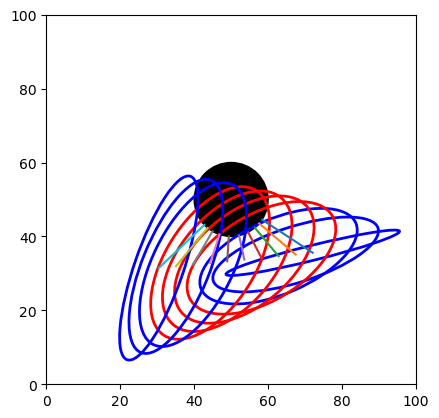

In [4]:
roadmap = Map(100, 100)
pos = np.array([50, 50])
obs = CircleObstacle(pos, 10)
thresh = -8
tolerance = 0.95
alpha = 0.95 
num_g_node = 10 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov

    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    visualize_g_node(g_node, ax, tolerance, is_collision)

## Voronoi Diagram

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, LineString, MultiPoint

def compute_voronoi(points, bounding_polygon):
    """
    Compute Voronoi diagram clipped by a bounding polygon.
    """
    vor = Voronoi(points)
    regions = []
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            continue
        polygon_points = [vor.vertices[i] for i in region_index]
        voronoi_polygon = Polygon(polygon_points)
        if bounding_polygon.contains(voronoi_polygon):
            regions.append(voronoi_polygon.intersection(bounding_polygon))
        else:
            regions.append(None)
    return vor, regions

def compute_centroids(regions):
    """
    Compute centroids of the Voronoi cells.
    """
    centroids = []
    for region in regions:
        if region and not region.is_empty:
            centroids.append(region.centroid.coords[0])
    return np.array(centroids)

def compute_voronoi_with_clipping(points, bounding_polygon):
    """
    Compute Voronoi diagram clipped by a bounding polygon.
    """
    vor = Voronoi(points)
    new_regions = []
    new_vertices = [tuple(v) for v in vor.vertices]  # Convert vertices to tuples

    # Map infinite regions to the boundary polygon
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            # Handle infinite regions
            region = [v for v in region_index if v != -1]
            if not region:
                continue
            
            # Start with finite vertices
            new_region = [tuple(vor.vertices[v]) for v in region]  # Convert to tuples
            
            # Find the ridges that go to infinity
            for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
                simplex = np.asarray(simplex)
                if np.any(simplex < 0):  # Infinite ridge
                    i = simplex[simplex >= 0][0]  # Finite endpoint of the ridge
                    
                    # Direction of the line from the finite point towards infinity
                    t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                    t = t / np.linalg.norm(t)
                    n = np.array([-t[1], t[0]])  # normal vector

                    # Compute a point far away in the direction of the normal
                    far_point = vor.vertices[i] + n * 1000

                    # Clip the line with the bounding polygon
                    line = LineString([vor.vertices[i], far_point])
                    clipped_line = line.intersection(bounding_polygon)
                    
                    if not clipped_line.is_empty:
                        # Handle different types of intersections (Point, MultiPoint)
                        if isinstance(clipped_line, MultiPoint):
                            for point in clipped_line:
                                point_tuple = tuple(point.coords[0])
                                if point_tuple not in new_vertices:
                                    new_region.append(point_tuple)
                                    new_vertices.append(point_tuple)
                        elif isinstance(clipped_line, Point):
                            point_tuple = tuple(clipped_line.coords[0])
                            if point_tuple not in new_vertices:
                                new_region.append(point_tuple)
                                new_vertices.append(point_tuple)
            
            # Convert back to indices
            new_region = [new_vertices.index(vertex) for vertex in new_region]
            new_regions.append(new_region)
        else:
            # Handle finite regions
            new_regions.append(region_index)
    
    return new_regions, np.array(new_vertices)

def plot_voronoi_with_clipping(voronoi, regions, vertices, obstacles, bounding_polygon):
    """
    Plot Voronoi diagram with the clipped regions for infinite cells.
    """
    plt.figure(figsize=(10, 10))

    # Plot each valid Voronoi region
    for region in regions:
        polygon_points = [vertices[i] for i in region]

        # Ensure valid polygon has at least 4 points and forms a closed loop
        if len(polygon_points) < 3:
            continue  # Skip if not enough points to form a polygon

        if len(polygon_points) >= 3 and polygon_points[0][0] != polygon_points[-1][0] and polygon_points[0][1] != polygon_points[-1][1]:
            polygon_points.append(polygon_points[0])  # Close the loop if needed
        
        if len(polygon_points) < 4:
            continue  # Ensure the polygon is valid

        voronoi_polygon = Polygon(polygon_points)
        
        # Clip the Voronoi cell with the bounding polygon
        voronoi_polygon = voronoi_polygon.intersection(bounding_polygon)
        
        # Exclude regions that overlap with obstacles
        if voronoi_polygon.is_empty or any(voronoi_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        x, y = voronoi_polygon.exterior.xy
        plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot original Voronoi sites
    plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram with Clipped Infinite Regions")
    plt.show()

# Generate random initial points (Voronoi sites)


In [6]:
num_samples = 500
num_iterations = 100

np.random.seed(42)
points = np.random.rand(num_samples, 2) * 100  # 20 random points in a 100x100 space

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Bounding polygon to limit Voronoi diagram to a finite area
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Compute Voronoi diagram with infinite regions clipped
for i in range(num_iterations):
    vor, regions = compute_voronoi(points, bounding_polygon)
    centroids = compute_centroids(regions) # Compute centroids of the Voronoi cells
    points = centroids # Update points to centroids

voronoi = Voronoi(points)
regions, vertices = compute_voronoi_with_clipping(points, bounding_polygon)

# Plot the resulting Voronoi diagram after clipping
plot_voronoi_with_clipping(voronoi, regions, vertices, obstacles, bounding_polygon)


ValueError: Input points array must have 2 dimensions.


### CVT test

51


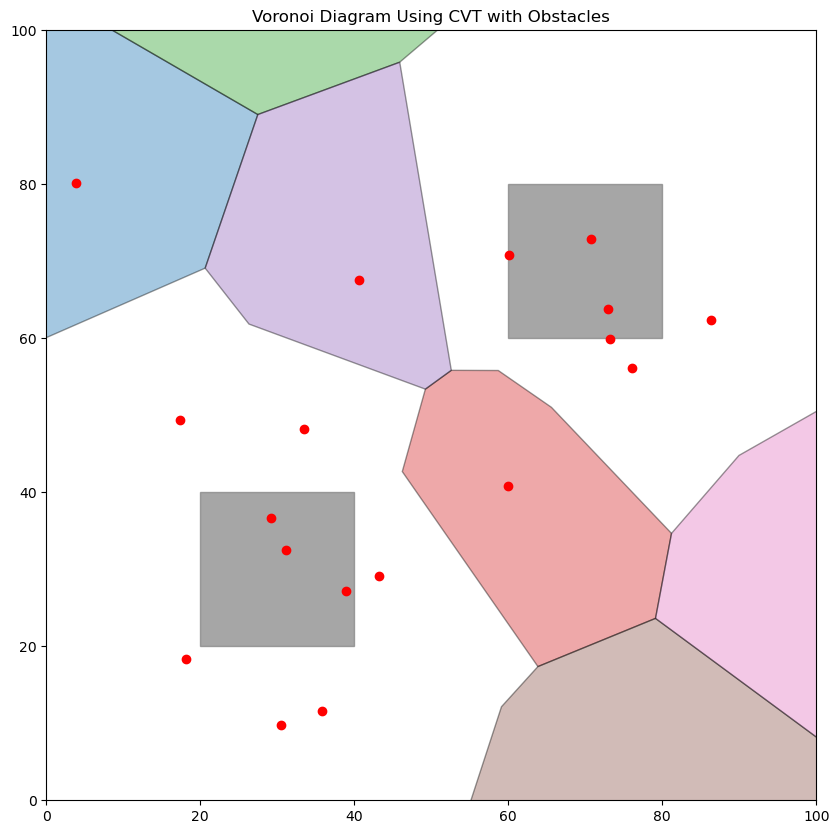

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                new_points.append(cell_polygon.centroid.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot Voronoi sites
    plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(50, 2) * 100  # 30 random points in a 100x100 space

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 10
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles
    points = compute_centroids(voronoi, points, obstacles)

print(len(voronoi.regions))
# Plot the resulting Voronoi diagram after CVT
plot_voronoi(voronoi, obstacles)



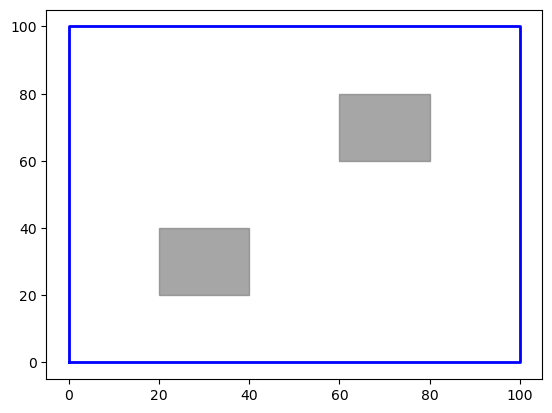

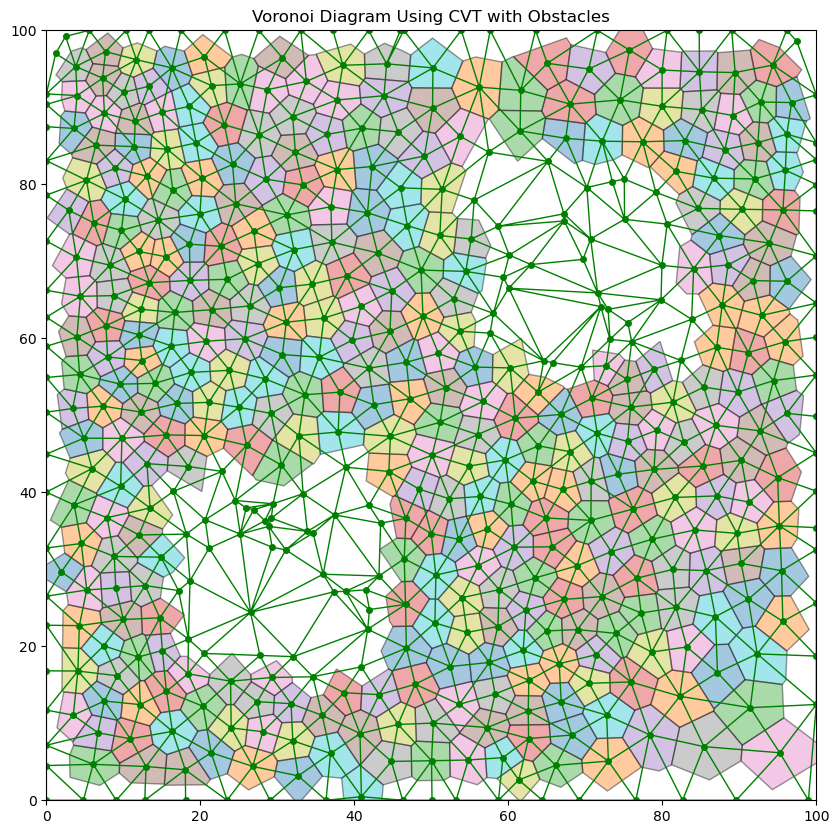

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, Delaunay
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, bounding_polygon, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect or go outside the bounding polygon.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                centroid = cell_polygon.centroid
                # Ensure the centroid is inside the bounding polygon
                if bounding_polygon.contains(centroid):
                    new_points.append(centroid.coords[0])
                else:
                    # If centroid is outside, keep the original point
                    # Alternatively, you could project it back onto the bounding polygon boundary
                    closest_point = bounding_polygon.exterior.interpolate(bounding_polygon.exterior.project(centroid))
                    new_points.append(closest_point.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, bounding_polygon, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

def plot_delaunay(tri):
    plt.triplot(points[:, 0], points[:, 1], tri.simplices, 'go-', lw=1, markersize=4)

# Plot Voronoi sites
# plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')


# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(500, 2) * 100  # 30 random points in a 100x100 space

# Define bounding polygon (a rectangular boundary)
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 10
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles, constrained to the bounding polygon
    points = compute_centroids(voronoi, points, bounding_polygon, obstacles)

# Plot the resulting Voronoi diagram after CVT
# Plot bounding polygon
x, y = bounding_polygon.exterior.xy
plt.plot(x, y, 'b-', lw=2)

# Plot obstacles
for obs in obstacles:
    x, y = obs.exterior.xy
    plt.fill(x, y, color='gray', alpha=0.7)

voronoi = compute_voronoi(points)
plot_voronoi(voronoi, bounding_polygon, obstacles)
tri = Delaunay(points)
plot_delaunay(tri)


plt.xlim(0, 100)
plt.ylim(0, 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Voronoi Diagram Using CVT with Obstacles")
plt.show()


### APF

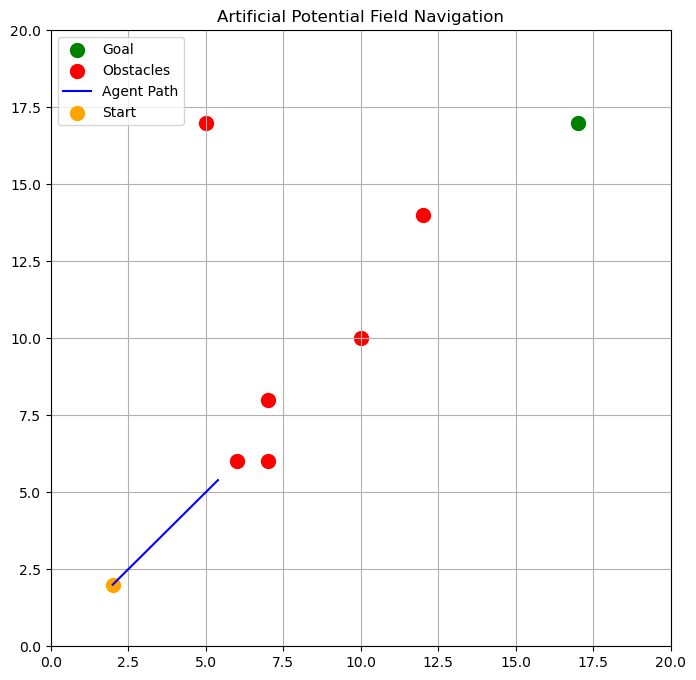

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the artificial potential field
def attractive_potential(pos, goal, zeta=1.0):
    """Attractive potential (pulls agent toward goal)"""
    return 0.5 * zeta * np.linalg.norm(pos - goal) ** 2

def attractive_force(pos, goal, zeta=1.0):
    """Attractive force derived from the attractive potential"""
    return -zeta * (pos - goal)

def repulsive_potential(pos, obstacle, eta=100.0, Q=1.0):
    """Repulsive potential (pushes agent away from obstacles)"""
    dist = np.linalg.norm(pos - obstacle)
    if dist <= Q:
        return 0.5 * eta * ((1.0 / dist - 1.0 / Q) ** 2)
    else:
        return 0

def repulsive_force(pos, obstacle, eta=100.0, Q=1.0):
    """Repulsive force derived from the repulsive potential"""
    dist = np.linalg.norm(pos - obstacle)
    if dist <= Q:
        return eta * (1.0 / dist - 1.0 / Q) * (1.0 / dist ** 3) * (pos - obstacle)
    else:
        return np.array([0.0, 0.0])

def total_force(pos, goal, obstacles):
    """Compute the total force acting on the agent at a given position"""
    total_f = attractive_force(pos, goal)
    for obs in obstacles:
        total_f += repulsive_force(pos, obs)
    return total_f

# Environment setup
grid_size = (20, 20)
start = np.array([2, 2])
goal = np.array([17, 17])
obstacles = np.array([[10, 10], [12, 14], [5, 17], [7, 8], [6, 6], [7, 6]])  # Example obstacle locations

# Simulation parameters
max_iterations = 1000
epsilon = 0.1  # Step size
threshold = 0.5  # Distance to goal to stop

# Initialize position
pos = start.copy()
trajectory = [pos.copy()]  # Store the trajectory for visualization

# Planning loop using artificial potential field
for i in range(max_iterations):
    force = total_force(pos, goal, obstacles)
    pos = pos + epsilon * force / np.linalg.norm(force)
    trajectory.append(pos.copy())
    
    # Stop if the agent reaches the goal
    if np.linalg.norm(pos - goal) < threshold:
        print(f"Reached goal in {i} iterations")
        break

# Visualization
trajectory = np.array(trajectory)

plt.figure(figsize=(8, 8))
plt.grid(True)
plt.xlim(0, grid_size[0])
plt.ylim(0, grid_size[1])
plt.scatter(goal[0], goal[1], color='green', label="Goal", s=100)
plt.scatter(obstacles[:, 0], obstacles[:, 1], color='red', label="Obstacles", s=100)
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label="Agent Path")
plt.scatter(start[0], start[1], color='orange', label="Start", s=100)
plt.legend()
plt.title('Artificial Potential Field Navigation')
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math

class GaussianState:
    def __init__(self, mean, covariance):
        self.mean = mean
        self.covariance = covariance

    def is_in_collision(self, obstacles):
        # Define a function that checks whether the Gaussian state collides with any obstacle
        for obstacle in obstacles:
            if self.collides_with(obstacle):
                return True
        return False

    def collides_with(self, obstacle):
        # Assume obstacles are circular for simplicity
        distance = np.linalg.norm(self.mean - obstacle['center'])
        return distance <= obstacle['radius']


class Node:
    def __init__(self, state):
        self.state = state
        self.parent = None
        self.cost = 0.0


class RRTStar:
    def __init__(self, start, goal, obstacles, bounds, step_size=0.5, max_iter=500):
        self.start = Node(start)
        self.goal = Node(goal)
        self.obstacles = obstacles
        self.bounds = bounds
        self.step_size = step_size
        self.max_iter = max_iter
        self.tree = [self.start]

    def distance(self, node1, node2):
        return np.linalg.norm(node1.state.mean - node2.state.mean)

    def steer(self, from_node, to_node):
        direction = to_node.state.mean - from_node.state.mean
        distance = np.linalg.norm(direction)
        if distance > self.step_size:
            direction = direction / distance * self.step_size
        new_mean = from_node.state.mean + direction
        new_covariance = np.copy(from_node.state.covariance)
        new_state = GaussianState(new_mean, new_covariance)
        return Node(new_state)

    def get_nearest(self, node):
        return min(self.tree, key=lambda n: self.distance(n, node))

    def get_near_nodes(self, new_node, radius):
        return [node for node in self.tree if self.distance(node, new_node) < radius]

    def rewire(self, new_node, near_nodes):
        for near_node in near_nodes:
            new_cost = new_node.cost + self.distance(new_node, near_node)
            if new_cost < near_node.cost:
                if not self.check_collision(new_node, near_node):
                    near_node.parent = new_node
                    near_node.cost = new_cost

    def check_collision(self, node1, node2):
        for t in np.linspace(0, 1, 10):
            interpolated_mean = (1 - t) * node1.state.mean + t * node2.state.mean
            interpolated_state = GaussianState(interpolated_mean, np.copy(node1.state.covariance))
            if interpolated_state.is_in_collision(self.obstacles):
                return True
        return False

    def sample(self):
        mean = np.random.uniform(self.bounds[0], self.bounds[1], size=2)
        covariance = np.eye(2) * 0.1
        return GaussianState(mean, covariance)

    def plan(self):
        for i in range(self.max_iter):
            rand_state = self.sample()
            rand_node = Node(rand_state)
            nearest_node = self.get_nearest(rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if not self.check_collision(nearest_node, new_node):
                near_nodes = self.get_near_nodes(new_node, radius=self.step_size * 5)
                self.tree.append(new_node)

                # Set the best parent and calculate cost
                best_node = nearest_node
                best_cost = nearest_node.cost + self.distance(nearest_node, new_node)
                for near_node in near_nodes:
                    new_cost = near_node.cost + self.distance(near_node, new_node)
                    if new_cost < best_cost and not self.check_collision(near_node, new_node):
                        best_node = near_node
                        best_cost = new_cost

                new_node.parent = best_node
                new_node.cost = best_cost

                # Rewire the tree
                self.rewire(new_node, near_nodes)

                # If close to goal, return path
                if self.distance(new_node, self.goal) < self.step_size:
                    self.goal.parent = new_node
                    self.goal.cost = new_node.cost + self.distance(new_node, self.goal)
                    return self.construct_path()

        return None

    def construct_path(self):
        path = []
        node = self.goal
        while node is not None:
            path.append(node.state)
            node = node.parent
        return path[::-1]

    def visualize(self, path):
        fig, ax = plt.subplots()
        # Plot start and goal
        ax.plot(self.start.state.mean[0], self.start.state.mean[1], 'go', label='Start')
        ax.plot(self.goal.state.mean[0], self.goal.state.mean[1], 'ro', label='Goal')

        # Plot obstacles (assuming circular obstacles)
        for obstacle in self.obstacles:
            circle = plt.Circle(obstacle['center'], obstacle['radius'], color='gray', alpha=0.5)
            ax.add_patch(circle)

        # Plot the solution path
        if path:
            path_points = np.array([node.mean for node in path])
            ax.plot(path_points[:, 0], path_points[:, 1], 'b-', linewidth=2, label='Path')
            ax.plot(path_points[:, 0], path_points[:, 1], 'bo')

        ax.set_xlim(self.bounds[0])
        ax.set_ylim(self.bounds[1])
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()
        plt.show()


# Example usage
start = GaussianState(np.array([0, 0]), np.eye(2))
goal = GaussianState(np.array([10, 10]), np.eye(2))
obstacles = [
    {'center': np.array([4, 4]), 'radius': 1.0},
    {'center': np.array([6, 6]), 'radius': 1.0}
]
bounds = [[-2, 12], [-2, 12]]

rrt_star = RRTStar(start, goal, obstacles, bounds, step_size=0.5, max_iter=1000)
path = rrt_star.plan()

if path:
    print("Path found!")
    rrt_star.visualize(path)
else:
    print("No path found.")


No path found.
